In [1]:
"""
Created on Tue, 10 Aug 2018
"""

'\nCreated on Tue, 10 Aug 2018\n'

In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

## Cleaning Dataset

### ***Create label for 1:n years ahead of crisis starts***

In [5]:
fulldata = pd.read_pickle('./fulldata_cp.pkl')

#drop unused columns:
fulldata = fulldata.drop(['country','year','lv_banking_end',
               'lv_banking_start','lv_banking_period','ifs_code'], axis =1)

fulldata = fulldata.drop(['SNIG4_VEE','SB4_VEE',
                          'L_DA_BA_GDP_VEE','LNBA_GDP_VEE'], axis=1)

fulldata = fulldata.drop(columns=['crisis_pre1','crisis_pre2'])

fulldata.set_index('country_year')

,income,GINI_VELIC,CPIA_VELIC,NGDP_R_PCH_WX001_VELIC,NGDP_RPCH_VELIC,NGDPRPC_PCH_VELIC,IAR_BP6_VELIC,GDVI_gini_VELIC,GDVI_gdppc_VELIC,GDVI_pplaffect_VELIC,...,SocioEcon_Conditions_VEE,Military_Politics_VEE,Internal_Conflict_VEE,Government_Stability_VEE,Democratic_Accountability_VEE,GGXCNL_GDP_VELIC,cred_gdp,cred_gr,infl,crisis_pre
country_year,,,,,,,,,,,,,,,,,,,,,
9141970,VEE,nan,nan,nan,2.7,0.1,nan,nan,5.6,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
9141971,VEE,nan,nan,nan,2.7,0.2,nan,nan,5.6,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
9141972,VEE,nan,nan,nan,2.7,0.3,nan,nan,5.6,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
9141973,VEE,nan,nan,nan,2.7,0.3,nan,nan,5.6,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
9141974,VEE,nan,nan,nan,2.7,0.4,nan,nan,5.6,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982011,VELIC,43.2,2.2,4.1,16.3,15.2,1.4,43.2,-1.4,nan,...,1.0,2.0,8.3,5.7,2.0,5.7,nan,nan,nan,0.0
6982012,VELIC,43.2,2.3,3.2,13.6,8.4,1.3,43.2,-1.4,nan,...,1.0,2.0,8.5,6.0,2.0,5.7,nan,nan,nan,0.0
6982013,VELIC,43.2,2.7,3.5,5.3,2.4,1.1,43.2,-1.4,nan,...,1.2,2.0,8.6,6.7,2.2,5.7,nan,nan,nan,0.0


### ***One hot encoding for Income variable (VEA, VEE, VELIC)***

In [6]:
fulldata.describe(include =['O'])
# pd.get_dummies(fulldata.income)
fulldata = fulldata.join(pd.get_dummies(fulldata.income))

## Preprocess Feature and Targets

In [7]:
def preprocess_features(df):
    
    # feature normalization for continuous variables
    con_column_name = df.drop(columns = ['country_year','income','crisis_pre','VELIC']).columns
    
    processed_features = df[con_column_name].copy()
    
    processed_features = (processed_features - processed_features.mean(axis = 0)) /processed_features.std(axis = 0)

    # impute missing continuous variables
    from sklearn.preprocessing import Imputer
    myImputer = Imputer(strategy = 'median')

    processed_features_np = myImputer.fit_transform(processed_features)
    processed_features = pd.DataFrame(processed_features_np, columns= con_column_name)
    
    return processed_features


In [8]:
def preprocess_targets(df) :
    
    output_targets = pd.DataFrame()
    output_targets['crisis_pre'] = df['crisis_pre'].astype(float)
    
    return output_targets
    

In [9]:
# Shuffle data and create training and validation set

from sklearn.utils import shuffle
np.random.seed(50)  
fulldata_shuffled = shuffle(fulldata)
fulldata_shuffled.head()

sample_size = fulldata_shuffled.shape[0]

training_x = preprocess_features(fulldata_shuffled.head(6000))
training_y = preprocess_targets(fulldata_shuffled.head(6000))

validation_x = preprocess_features(fulldata_shuffled.tail(sample_size-6000))
validation_y = preprocess_targets(fulldata_shuffled.tail(sample_size-6000))

training_crisis_percent = training_y.mean(axis= 0)
validation_crisis_percent = validation_y.mean(axis =0)

print("crisis in traing set {:.1%}".format(training_crisis_percent['crisis_pre']))
print("\ncrisis in validation set {:.1%}".format(validation_crisis_percent['crisis_pre']))

crisis in traing set 4.2%

crisis in validation set 4.1%


### ***Caution: training and validation set should contain similar % of crisis. Otherwise loss in validation could be even lower than training set***

In [10]:
# Create tensorflow feature column for DNN (just using names)
def construct_feature_columns(feature_example):
    
    my_tf_feature =[]
    # 1. create tf feature columns for each continuous feature column
    [my_tf_feature.append(tf.feature_column.numeric_column(col)) for col in feature_example ]
    # 2. add categorical column as an alternative
    # myFeature.append(
    #     tf.feature_column.categorical_column_with_vocabulary_list(
    #     key = 'income', vocabulary_list =['VEE','VEA','VELIC']))
    return my_tf_feature
    

## Create Input Function

In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    from tensorflow.python.data import Dataset
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Build and Train NN Model

In [12]:
def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    """Trains a neural network classification model.

    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `fulldataShuffled` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `fulldataShuffled` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
     `fulldataShuffled` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `fulldataShuffled` to use as target for validation.

    Returns:
    A `DNNClassifier` object trained on the training data.
    """
    #tf.estimator.periods = 10
    periods = 10  
    steps_per_period = steps / periods

    # Create a DNNRegressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    
    dnn_classifier = tf.estimator.DNNClassifier(
        feature_columns= construct_feature_columns(training_examples),
        hidden_units= hidden_units,
        optimizer= my_optimizer,
        activation_fn= tf.nn.tanh,
#         dropout = 0.2      #added
#         batch_norm = True
    )

    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets['crisis_pre'], 
                                          batch_size=batch_size,
                                          )
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets['crisis_pre'], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets['crisis_pre'], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training and validation data):")
    training_log_losses = []
    validation_log_losses = []
    
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        dnn_classifier.train(
            input_fn= training_input_fn,
            steps= steps_per_period
        )
        # Take a break and compute predictions.
        training_probabilities = dnn_classifier.predict(input_fn= predict_training_input_fn)  
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = dnn_classifier.predict(input_fn= predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        # Compute training and validation loss.
        # from IPython import embed; embed()
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.# Occasionally print the current loss.
        print("  period %02d : %0.2f, : %0.2f" % (period, training_log_loss, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return dnn_classifier

Training model...
LogLoss (on training and validation data):
  period 00 : 0.14, : 0.15
  period 01 : 0.12, : 0.14
  period 02 : 0.12, : 0.14
  period 03 : 0.11, : 0.14
  period 04 : 0.10, : 0.13
  period 05 : 0.10, : 0.13
  period 06 : 0.09, : 0.13
  period 07 : 0.09, : 0.13
  period 08 : 0.08, : 0.13
  period 09 : 0.08, : 0.12
Model training finished.
----387.3332004547119 seconds----


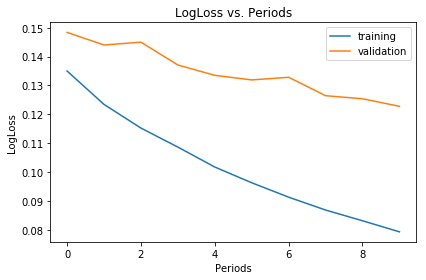

In [13]:
import time
start_time = time.time()

dnn_classifier = train_nn_classification_model(
    learning_rate=0.01,
    steps=10000,
    batch_size=60,
    hidden_units=[100, 20],
    training_examples= training_x,
    training_targets= training_y,
    validation_examples= validation_x,
    validation_targets= validation_y)

print("----%s seconds----" % (time.time()-start_time) )

## Calculate and plot ROC for Training and Validation Set

In [14]:
predict_validation_input_fn = lambda: my_input_fn(validation_x, 
                                                    validation_y['crisis_pre'], 
                                                    num_epochs=1, 
                                                    shuffle=False)

predict_training_input_fn = lambda: my_input_fn(training_x, 
                                                  training_y['crisis_pre'], 
                                                  num_epochs=1, 
                                                  shuffle=False)

training_metrics = dnn_classifier.evaluate(input_fn = predict_training_input_fn)
evaluation_metrics = dnn_classifier.evaluate(input_fn = predict_validation_input_fn)

# print("Training:")
# print("AUC on the training set: %0.2f" % training_metrics['auc'])
# print("Accuracy on the training set: %0.2f" % training_metrics['accuracy'])
# print("Validation:")
# print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
# print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print(training_metrics)
print(evaluation_metrics)

{'accuracy': 0.97466666, 'accuracy_baseline': 0.9575, 'average_loss': 0.079314396, 'auc_precision_recall': 0.75882894, 'precision': 0.9327731, 'auc': 0.9593205, 'global_step': 10000, 'recall': 0.43529412, 'label/mean': 0.0425, 'loss': 0.079314396, 'prediction/mean': 0.042772226}
{'accuracy': 0.9633911, 'accuracy_baseline': 0.9585742, 'average_loss': 0.122786865, 'auc_precision_recall': 0.35387707, 'precision': 0.7777778, 'auc': 0.87935024, 'global_step': 10000, 'recall': 0.1627907, 'label/mean': 0.04142582, 'loss': 0.122786865, 'prediction/mean': 0.039252974}


In [15]:
def plot_roc(true_y,pred_y):
    fpr, tpr, thresholds = metrics.roc_curve(true_y, pred_y, pos_label=1)
    score = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % score)
    plt.legend(loc="lower right")
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

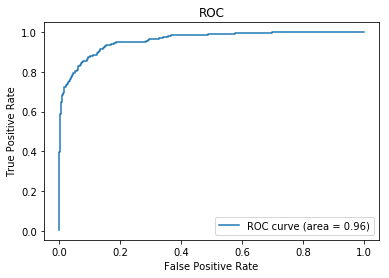

In [16]:
training_prediction = dnn_classifier.predict(input_fn = predict_training_input_fn)
training_probabilities =[item['probabilities'][1] for item in training_prediction]

plot_roc(training_y['crisis_pre'], training_probabilities)

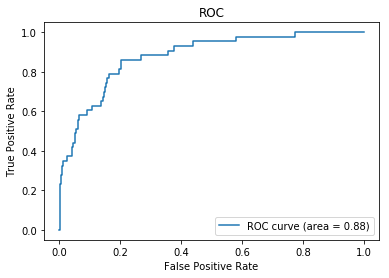

In [17]:
evaluation_prediction = dnn_classifier.predict(input_fn = predict_validation_input_fn )
evaluation_probabilities =[item['probabilities'][1] for item in evaluation_prediction]
plot_roc(validation_y['crisis_pre'], evaluation_probabilities)